In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import sklearn

from matplotlib.gridspec import GridSpec
sns.set(style="ticks")
%matplotlib inline

from scipy.stats import norm
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
##defining a function to find the upper and lower limits
def outlier(x) :
    Q1 = np.quantile(x,0.25,interpolation='midpoint')
    Q3 = np.quantile(x,0.75,interpolation='midpoint')
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    return upper, lower

In [3]:
# Function to create dummy variables

def dummies(x,df):
    temp = pd.get_dummies(df[x], prefix=x, drop_first = True)
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis =1, inplace = True)
    return df

In [4]:
def plotLiftChart(actual, predicted,title_str):
    df_dict = {'actual': list (actual), 'pred': list(predicted)}
    df = pd.DataFrame(df_dict)
    pred_ranks = pd.qcut(df['pred'].rank(method='first'), 100, labels=False)
    actual_ranks = pd.qcut(df['actual'].rank(method='first'), 100, labels=False)
    pred_percentiles = df.groupby(pred_ranks).mean()
    actual_percentiles = df.groupby(actual_ranks).mean()
    plt.title(title_str)
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['pred']),
             color='darkorange', lw=2, label='Prediction')
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['actual']),
             color='navy', lw=2, linestyle='--', label='Actual')
    plt.ylabel('Target Percentile')
    plt.xlabel('Population Percentile')
    plt.xlim([0.0, 1.0])
    plt.ylim([-0.05, 1.05])
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 4

    plt.legend(loc="best")
    plt.show()

## What is Churn?
Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time have potentially shifted to another service provider. Since around 80% of revenue comes from the top 20% customers, hence we are concentrating on high value customers. So if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

## Who are High value customers?
High-value customers are those who have recharged with an amount more than or equal the 70th percentile of the average recharge amount in the first two months (the good phase). Once high value customers are identified, we will tag churn customers based on who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase.

## What are Customer Lifecycle phases?
Good phase: wherein the customer is happy with the service and is regularly generating revenue for the company (Months 6 & 7)

Action phase: wherein the customer either wasn't happy with service or got a better offer from competitor. It is crucial to identify such high-churn-risk customers in this phase, so that some corrective actions can be taken at this point to prevet churn (Month 8)

Churn phase: wherein the customer would have churned

# Step 1 : Understanding and Cleaning the Data

In [5]:
#Load the train data. NOTE: the file name has been changed from train(1).csv to train.csv
data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [6]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [7]:
data.shape

(69999, 172)

In [8]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [9]:
# Identify the High Value Customers before the cleanup
data['total_data_rech_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['total_data_rech_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

data['amt_data_6'] = data[['total_rech_amt_6','total_data_rech_6']].sum(axis=1)
data['amt_data_7'] = data[['total_rech_amt_7','total_data_rech_7']].sum(axis=1)

data['AVG_amt_data_6_7'] = data[['amt_data_6','amt_data_7']].mean(axis=1)

In [10]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0,NaN,NaN,77.0,65.0,71.0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/20

In [11]:
data[['total_rech_amt_6','total_rech_amt_7','AVG_amt_data_6_7']].quantile(np.linspace(.1, 1, 9, 0))

,total_rech_amt_6,total_rech_amt_7,AVG_amt_data_6_7
0.1,0.0,0.0,60.0
0.2,80.0,65.0,108.5
0.3,120.0,110.0,155.0
0.4,170.0,160.0,210.0
0.5,229.0,220.0,275.5
0.6,290.0,284.0,361.0
0.7,378.0,370.0,477.5
0.8,504.0,500.0,656.0
0.9,735.0,730.0,1029.0


In [12]:
df = data[(data['AVG_amt_data_6_7']> data['AVG_amt_data_6_7'].quantile(0.7))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 4 to 69997
Columns: 177 entries, id to AVG_amt_data_6_7
dtypes: float64(140), int64(28), object(9)
memory usage: 28.5+ MB


In [13]:
# Identifying churn high value customers based on the last month i.e. month 8
df['churn_flag'] = np.where(
                            ((df['total_ic_mou_8'] == 0.00) | (df['total_og_mou_8'] == 0.00))
                            & ((df['vol_2g_mb_8'] == 0.00) | (df['vol_3g_mb_8'] == 0.00))
                            , 1, 0
                           )

In [14]:
print(df['churn_flag'].value_counts())
print(df['churn_flag'].value_counts()/df.shape[0])

0    19361
1     1637
Name: churn_flag, dtype: int64
0    0.92204
1    0.07796
Name: churn_flag, dtype: float64


In [15]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 4 to 69997
Data columns (total 178 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        20998 non-null  int64  
 1    circle_id                 20998 non-null  int64  
 2    loc_og_t2o_mou            20831 non-null  float64
 3    std_og_t2o_mou            20831 non-null  float64
 4    loc_ic_t2o_mou            20831 non-null  float64
 5    last_date_of_month_6      20998 non-null  object 
 6    last_date_of_month_7      20983 non-null  object 
 7    last_date_of_month_8      20887 non-null  object 
 8    arpu_6                    20998 non-null  float64
 9    arpu_7                    20998 non-null  float64
 10   arpu_8                    20998 non-null  float64
 11   onnet_mou_6               20602 non-null  float64
 12   onnet_mou_7               20606 non-null  float64
 13   onnet_mou_8               20177 non-null  fl

In [16]:
df.shape

(20998, 178)

In [17]:
# sum it up to check how many rows have all missing values
print("Rows with all NULL values =",  df.isnull().all(axis=1).sum())

# sum of misisng values in each row
rows_missing_data = df.isnull().sum(axis=1)
rows_missing_data[rows_missing_data > 0]

Rows with all NULL values = 0


15        11
23        32
33        69
49        32
52        32
54        39
57        11
68        32
75        10
78        21
79        32
80        11
81        32
84        32
88        22
89        11
93        32
96        11
98        21
100       32
105       22
110       21
117       32
122       32
125       11
126       22
128       11
132       32
157       11
162       32
170       11
172       10
176       32
177       50
183       52
185       32
190       11
196       32
198       11
201       32
208       11
217       39
230       90
236       11
243       32
262       32
264       32
265       29
268       21
282       32
294       21
297       32
300       32
303       32
307       32
309       32
313       50
338       22
359       32
361       32
363       32
370       32
374       32
380       33
381       32
383       32
384       32
389       32
393       11
400       21
407       32
419       11
421       32
428       32
431       21
459       32
464       32

In [18]:
rows_missing_data.sort_values(ascending=False)

37361    126
3625     126
31870    126
45430    126
54165    122
17508    122
5526     122
10431    122
5233     122
22167    112
14502    112
56036    112
48214    111
29492    111
22799    111
64643    111
29355    111
10360    111
49607    111
29101    111
8479     111
35756    111
15521    111
45986    111
6417     111
12434    111
18741    102
45630    101
41964    101
54909    101
11790    101
60242    101
46188    101
32791    101
50767    101
62113    101
45924    101
52266    101
50725    101
58437    101
46976    101
5071     101
57508    101
58667    101
30031    100
63365    100
9789     100
32866    100
68967    100
46619    100
15310    100
15217    100
27243    100
23496    100
5302     100
23246    100
23875    100
32452    100
42577    100
29774    100
68757    100
20100    100
68695    100
20363    100
22302    100
52032    100
61661     98
33431     98
33422     97
36021     97
18994     94
38972     94
50302     92
37289     92
22081     91
46957     91
10230     91

In [19]:
# dropping the rows having 70% or more empty values i.e. 124 columns having null
drop_rows = df.isnull().sum(axis=1) >= 124
print("Number of rows with >= 124 missing values = {}".format(drop_rows.sum()))
print("     % of rows with >= 124 missing values = {} %".format(drop_rows.sum()/df.shape[0]*100))


Number of rows with >= 124 missing values = 4
     % of rows with >= 124 missing values = 0.01904943327935994 %


In [20]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 4 to 69997
Data columns (total 178 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        20998 non-null  int64  
 1    circle_id                 20998 non-null  int64  
 2    loc_og_t2o_mou            20831 non-null  float64
 3    std_og_t2o_mou            20831 non-null  float64
 4    loc_ic_t2o_mou            20831 non-null  float64
 5    last_date_of_month_6      20998 non-null  object 
 6    last_date_of_month_7      20983 non-null  object 
 7    last_date_of_month_8      20887 non-null  object 
 8    arpu_6                    20998 non-null  float64
 9    arpu_7                    20998 non-null  float64
 10   arpu_8                    20998 non-null  float64
 11   onnet_mou_6               20602 non-null  float64
 12   onnet_mou_7               20606 non-null  float64
 13   onnet_mou_8               20177 non-null  fl

In [21]:
# Columns with more than 70% missing values
colmns_missing_data = round(100*(df.isnull().sum()/len(df.index)), 2)
colmns_missing_data[colmns_missing_data >= 70]
# Since df contains high value customers, most of the columns have considerable amount of data

Series([], dtype: float64)

In [22]:
## Convert date_of_last_rech_6 --> rech_days_left_6 (voice rechanrged before number of days to month end)
## Convert date_of_last_rech_data_6 --> rech_data_days_left_6 (data recharged before number of days to month end)
# covert date columns to python datetime format
date_vars = ["date_of_last_rech_6", "date_of_last_rech_data_6", "date_of_last_rech_7", "date_of_last_rech_data_7", "date_of_last_rech_8", "date_of_last_rech_data_8"]
df[date_vars].head()

,date_of_last_rech_6,date_of_last_rech_data_6,date_of_last_rech_7,date_of_last_rech_data_7,date_of_last_rech_8,date_of_last_rech_data_8
4,6/25/2014,6/25/2014,7/26/2014,7/23/2014,8/30/2014,8/20/2014
15,6/27/2014,6/16/2014,7/25/2014,NaN,8/30/2014,8/2/2014
23,6/30/2014,NaN,7/31/2014,NaN,8/22/2014,NaN
24,6/24/2014,6/19/2014,7/25/2014,7/25/2014,8/30/2014,8/8/2014
27,6/29/2014,6/17/2014,7/20/2014,7/17/2014,8/23/2014,8/12/2014


In [23]:
# convert to datetime
for col in date_vars:
    df[col] = pd.to_datetime(df[col])

print(df[date_vars].info())
df[date_vars].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 4 to 69997
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date_of_last_rech_6       20946 non-null  datetime64[ns]
 1   date_of_last_rech_data_6  11685 non-null  datetime64[ns]
 2   date_of_last_rech_7       20930 non-null  datetime64[ns]
 3   date_of_last_rech_data_7  11914 non-null  datetime64[ns]
 4   date_of_last_rech_8       20603 non-null  datetime64[ns]
 5   date_of_last_rech_data_8  11176 non-null  datetime64[ns]
dtypes: datetime64[ns](6)
memory usage: 1.1 MB
None


,date_of_last_rech_6,date_of_last_rech_data_6,date_of_last_rech_7,date_of_last_rech_data_7,date_of_last_rech_8,date_of_last_rech_data_8
4,2014-06-25,2014-06-25,2014-07-26,2014-07-23,2014-08-30,2014-08-20
15,2014-06-27,2014-06-16,2014-07-25,NaT,2014-08-30,2014-08-02
23,2014-06-30,NaT,2014-07-31,NaT,2014-08-22,NaT
24,2014-06-24,2014-06-19,2014-07-25,2014-07-25,2014-08-30,2014-08-08
27,2014-06-29,2014-06-17,2014-07-20,2014-07-17,2014-08-23,2014-08-12


In [24]:
# Create new days columns, instead of date
import datetime
last_date_of_month_6 = datetime.datetime.strptime("30-06-2014", "%d-%m-%Y")
last_date_of_month_7 = datetime.datetime.strptime("31-07-2014", "%d-%m-%Y")
last_date_of_month_8 = datetime.datetime.strptime("31-08-2014", "%d-%m-%Y")

df["rech_days_left_6"]      = (last_date_of_month_6 - df.date_of_last_rech_6).astype('timedelta64[D]')
df["rech_days_left_7"]      = (last_date_of_month_7 - df.date_of_last_rech_7).astype('timedelta64[D]')
df["rech_days_left_8"]      = (last_date_of_month_8 - df.date_of_last_rech_8).astype('timedelta64[D]')

df["rech_data_days_left_6"]      = (last_date_of_month_6 - df.date_of_last_rech_data_6).astype('timedelta64[D]')
df["rech_data_days_left_7"]      = (last_date_of_month_7 - df.date_of_last_rech_data_7).astype('timedelta64[D]')
df["rech_data_days_left_8"]      = (last_date_of_month_8 - df.date_of_last_rech_data_8).astype('timedelta64[D]')

day_columns = ["rech_days_left_6", "rech_days_left_7", "rech_days_left_8","rech_data_days_left_6","rech_data_days_left_7","rech_data_days_left_8"]
print(df[day_columns].head(10))


    rech_days_left_6  rech_days_left_7  rech_days_left_8  \
4                5.0               5.0               1.0   
15               3.0               6.0               1.0   
23               0.0               0.0               9.0   
24               6.0               6.0               1.0   
27               1.0              11.0               8.0   
33              22.0               4.0               0.0   
39               1.0               2.0               1.0   
45               0.0               1.0               9.0   
49               0.0               0.0               1.0   
52               0.0               5.0               0.0   

    rech_data_days_left_6  rech_data_days_left_7  rech_data_days_left_8  
4                     5.0                    8.0                   11.0  
15                   14.0                    NaN                   29.0  
23                    NaN                    NaN                    NaN  
24                   11.0                  

In [25]:
print(df[day_columns].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 4 to 69997
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rech_days_left_6       20946 non-null  float64
 1   rech_days_left_7       20930 non-null  float64
 2   rech_days_left_8       20603 non-null  float64
 3   rech_data_days_left_6  11685 non-null  float64
 4   rech_data_days_left_7  11914 non-null  float64
 5   rech_data_days_left_8  11176 non-null  float64
dtypes: float64(6)
memory usage: 1.1 MB
None


In [26]:
# Drop all old date columns
df.drop(date_vars, axis=1, inplace=True)

print('Number of columns droped here  = ', len(date_vars))
print('Dataframe Shape: ', df.shape)

Number of columns droped here  =  6
Dataframe Shape:  (20998, 178)


In [27]:
df[['rech_days_left_6', 'rech_days_left_7', 'rech_days_left_8','rech_data_days_left_6','rech_data_days_left_7','rech_data_days_left_8']].describe()

,rech_days_left_6,rech_days_left_7,rech_days_left_8,rech_data_days_left_6,rech_data_days_left_7,rech_data_days_left_8
count,20946.000000,20930.000000,20603.000000,11685.000000,11914.000000,11176.000000
mean,3.540724,3.708361,4.296122,9.887719,9.963992,10.681102
std,4.698388,4.610874,5.259670,8.351256,8.506759,8.690747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,3.000000,3.000000,3.000000
50%,2.000000,2.000000,3.000000,8.000000,7.000000,9.000000
75%,5.000000,5.000000,6.000000,16.000000,17.000000,18.000000
max,29.000000,30.000000,30.000000,29.000000,30.000000,30.000000


In [28]:
# Mean & Median are different: imputing with median value for recharge days left 
df.loc[np.isnan(df['rech_days_left_6']), ['rech_days_left_6']] = df['rech_days_left_6'].median()
df.loc[np.isnan(df['rech_days_left_7']), ['rech_days_left_7']] = df['rech_days_left_7'].median()
df.loc[np.isnan(df['rech_days_left_8']), ['rech_days_left_8']] = df['rech_days_left_8'].median()
df.loc[np.isnan(df['rech_data_days_left_6']), ['rech_data_days_left_6']] = df['rech_data_days_left_6'].median()
df.loc[np.isnan(df['rech_data_days_left_7']), ['rech_data_days_left_7']] = df['rech_data_days_left_7'].median()
df.loc[np.isnan(df['rech_data_days_left_8']), ['rech_data_days_left_8']] = df['rech_data_days_left_8'].median()

#round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print("\nTotal Number of missing values in the data frame = {}".format(df.isnull().sum().sum()))
print('Dataframe Shape: ', df.shape); 


Total Number of missing values in the data frame = 319656
Dataframe Shape:  (20998, 178)


In [29]:
df.head(5)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7,churn_flag,rech_days_left_6,rech_days_left_7,rech_days_left_8,rech_data_days_left_6,rech_data_days_left_7,rech_data_days_left_8
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,25,10,30,7.0,7.0,6.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,175.0,191.0,142.0,390.80,308.89,213.47,0.0,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.00,0.00,0,1225.0,1337.0,1515.0,1473.0,1494.0,0,5.0,5.0,1.0,5.0,8.0,11.0
15,15,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,6.26,0.0,0.0,0.0,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.00,0.00,0.00,0.00,1.03,0.0,0.0,0.0,0.0,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.0,0.0,0.0,0.0,0

In [30]:
#Looking at missing value percentage of columns

missingPercentage = df.isnull().sum() / df.shape[0] * 100.00
missingPercentage.sort_values(ascending=False).head(20) 

night_pck_user_8      46.775883
arpu_3g_8             46.775883
max_rech_data_8       46.775883
count_rech_2g_8       46.775883
count_rech_3g_8       46.775883
fb_user_8             46.775883
av_rech_amt_data_8    46.775883
arpu_2g_8             46.775883
total_rech_data_8     46.775883
arpu_2g_6             44.351843
total_data_rech_6     44.351843
arpu_3g_6             44.351843
max_rech_data_6       44.351843
av_rech_amt_data_6    44.351843
fb_user_6             44.351843
count_rech_3g_6       44.351843
night_pck_user_6      44.351843
total_rech_data_6     44.351843
count_rech_2g_6       44.351843
fb_user_7             43.261263
dtype: float64

In [31]:
#Can't drop columns as they have fair amount of data. Since these columns are related to usage of the services, replacing null with 0s
Telecom = df.fillna(0)

In [32]:
Telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20998 entries, 4 to 69997
Data columns (total 178 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    id                     20998 non-null  int64  
 1    circle_id              20998 non-null  int64  
 2    loc_og_t2o_mou         20998 non-null  float64
 3    std_og_t2o_mou         20998 non-null  float64
 4    loc_ic_t2o_mou         20998 non-null  float64
 5    last_date_of_month_6   20998 non-null  object 
 6    last_date_of_month_7   20998 non-null  object 
 7    last_date_of_month_8   20998 non-null  object 
 8    arpu_6                 20998 non-null  float64
 9    arpu_7                 20998 non-null  float64
 10   arpu_8                 20998 non-null  float64
 11   onnet_mou_6            20998 non-null  float64
 12   onnet_mou_7            20998 non-null  float64
 13   onnet_mou_8            20998 non-null  float64
 14   offnet_mou_6           20998 non-nul

In [33]:
#Looking at missing value percentage of columns

missingPercentage = Telecom.isnull().sum() / Telecom.shape[0] * 100.00
missingPercentage.sort_values(ascending=False).head(20) 

id                    0.0
vol_2g_mb_8           0.0
last_day_rch_amt_6    0.0
last_day_rch_amt_7    0.0
last_day_rch_amt_8    0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64

In [34]:
# New DERIVED Columns for Total Data Recharge Amount

Telecom["total_rech_data_amt_6"] = Telecom["total_rech_data_6"]*Telecom['av_rech_amt_data_6']
Telecom["total_rech_data_amt_7"] = Telecom["total_rech_data_7"]*Telecom['av_rech_amt_data_7']
Telecom["total_rech_data_amt_8"] = Telecom["total_rech_data_8"]*Telecom['av_rech_amt_data_8']

# We can drop total_rech_data_* and av_rech_amt_data_*
drop_data_columns = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8",  
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
Telecom.drop(drop_data_columns, axis=1, inplace=True)

In [35]:
# Identify columns that have no varience
telecom_unique_count = Telecom.nunique().sort_values(ascending=False)

# Identify bad colums that has no infromation (all entries are NA or same)
# Find columns with all NULL entries and add to drop_columns list
telecom_unique_count_is_zero = telecom_unique_count[telecom_unique_count == 0]
print("Dataframe Unique Value Count is ZERO (all null values): \n", telecom_unique_count_is_zero);
drop_no_varience_columns = list(telecom_unique_count_is_zero.index)

# Find columns with all same entries and add to drop_columns list
telecom_unique_count_is_one = telecom_unique_count[telecom_unique_count == 1]
print("Dataframe Unique Value Count is ONE (all same values): \n", telecom_unique_count_is_one); 
drop_no_varience_columns += list(telecom_unique_count_is_one.index)

print('Dataframe Shape: ', Telecom.shape); 
Telecom.drop(drop_no_varience_columns, axis=1, inplace=True)


print('Number of columns dropped here  = ', len(drop_no_varience_columns))
print('Dataframe Shape: ', Telecom.shape); 

Dataframe Unique Value Count is ZERO (all null values): 
 Series([], dtype: int64)
Dataframe Unique Value Count is ONE (all same values): 
 std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
last_date_of_month_6    1
loc_ic_t2o_mou          1
std_og_t2c_mou_8        1
std_ic_t2o_mou_6        1
circle_id               1
std_ic_t2o_mou_8        1
std_og_t2o_mou          1
loc_og_t2o_mou          1
std_ic_t2o_mou_7        1
dtype: int64
Dataframe Shape:  (20998, 175)
Number of columns dropped here  =  11
Dataframe Shape:  (20998, 164)


In [36]:
#checking whether data is imbalanced or not
churn  = Telecom["churn_flag"].value_counts()
churn_rate = churn[1]/(churn[1] + churn[0])

print("Total Churn Count     = {}".format(churn[1]))
print("Total Not-Churn Count = {}".format(churn[0]))
print("Churn Rate            = {:.2f}%".format(churn_rate*100))
# We can clearly see that the churn customers are ~8% only. So, we can infer that the dataset is an imbalanced one.

Total Churn Count     = 1637
Total Not-Churn Count = 19361
Churn Rate            = 7.80%


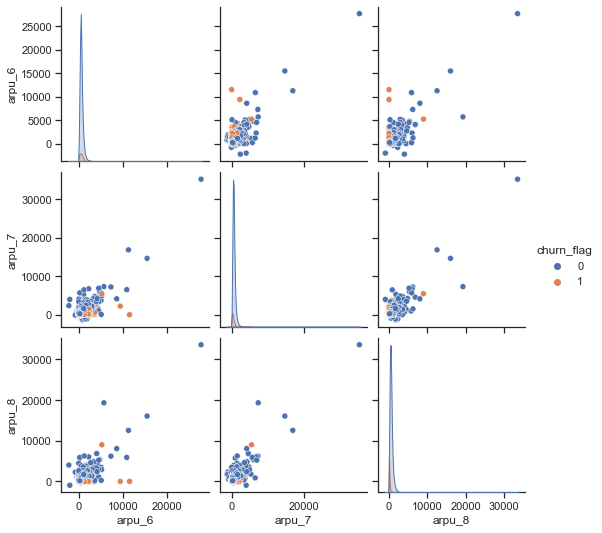

In [37]:
# arpu (Average Revenue per user)
sns.pairplot(data=Telecom[['arpu_6','arpu_7','arpu_8','churn_flag']],hue='churn_flag')

<AxesSubplot:xlabel='churn_flag', ylabel='arpu_6'>

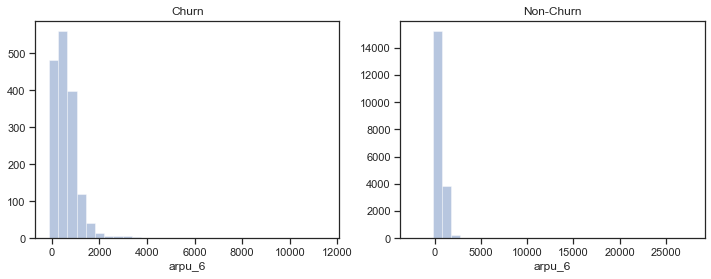

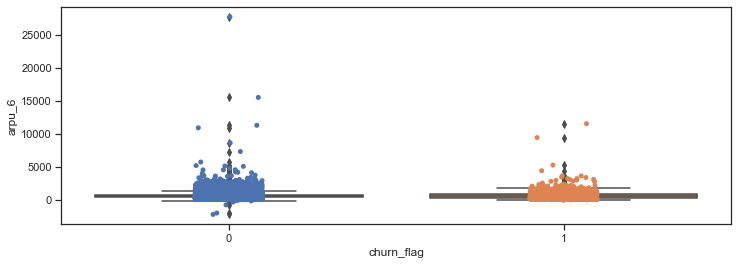

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(Telecom[Telecom['churn_flag']==1].arpu_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(Telecom[Telecom['churn_flag']==0].arpu_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='arpu_6', data=Telecom)
sns.stripplot(x='churn_flag', y='arpu_6', data=Telecom, jitter=True, edgecolor="gray")

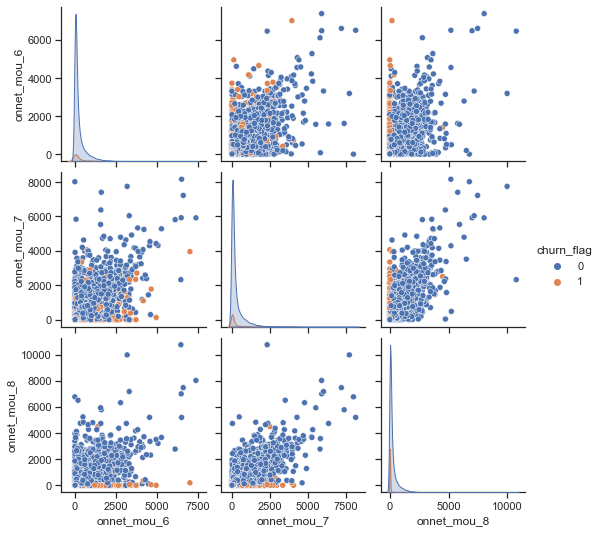

In [39]:
# onnet_mou (On network/ within the same network usage)
sns.pairplot(data=Telecom[['onnet_mou_6','onnet_mou_7','onnet_mou_8','churn_flag']],hue='churn_flag')

<AxesSubplot:xlabel='churn_flag', ylabel='onnet_mou_6'>

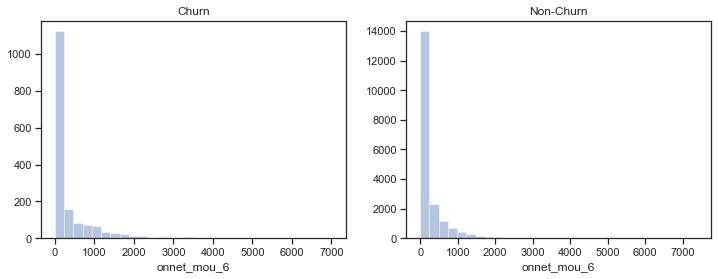

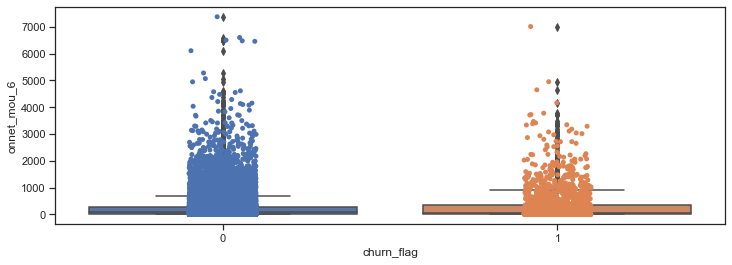

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(Telecom[Telecom['churn_flag']==1].onnet_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(Telecom[Telecom['churn_flag']==0].onnet_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='onnet_mou_6', data=Telecom)
sns.stripplot(x='churn_flag', y='onnet_mou_6', data=Telecom, jitter=True, edgecolor="gray")

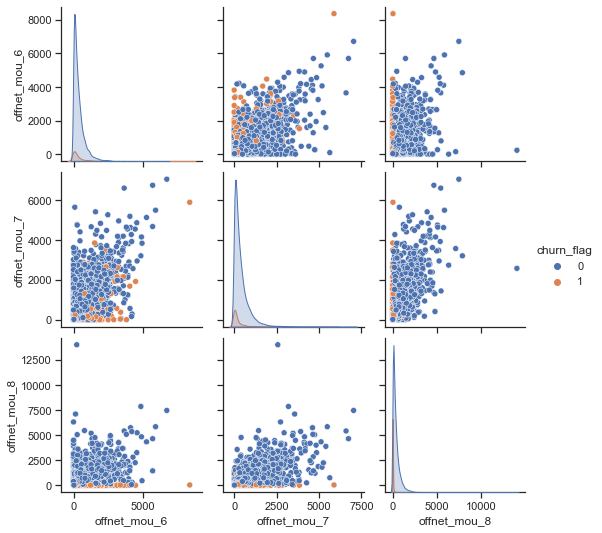

In [41]:
# Offnet_mou (Calls outside of the operator network)
sns.pairplot(data=Telecom[['offnet_mou_6','offnet_mou_7','offnet_mou_8','churn_flag']],hue='churn_flag')

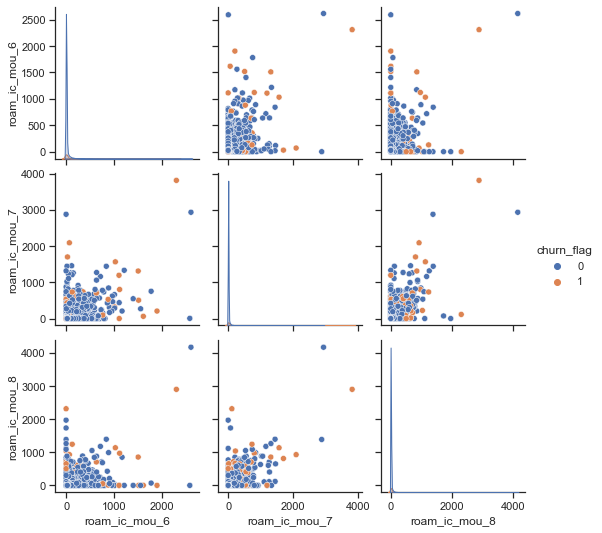

In [42]:
# roam_ic_mou (Customer in roaming zone)
sns.pairplot(data=Telecom[['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','churn_flag']],hue='churn_flag')

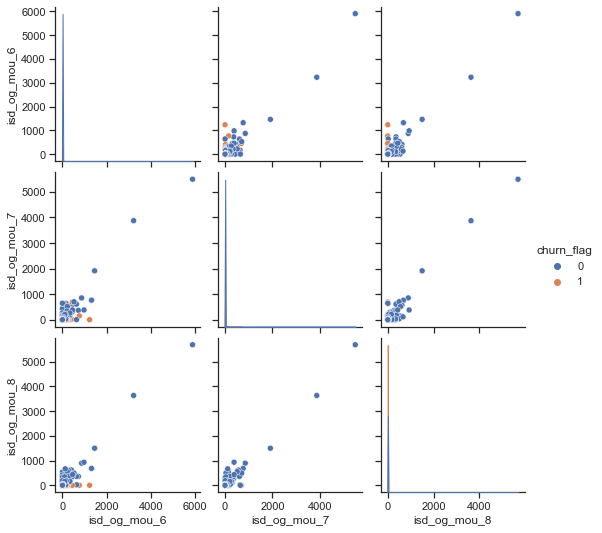

In [43]:
# isd_og (international calling)
sns.pairplot(data=Telecom[['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','churn_flag']],hue='churn_flag')

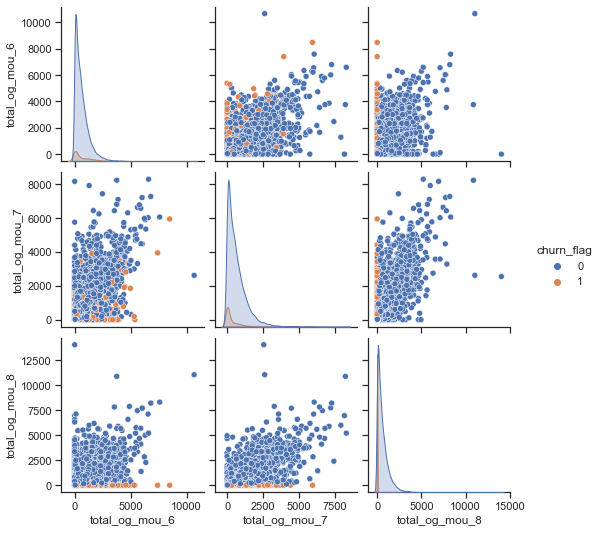

In [44]:
# totalog (All outgoing calls by the customer)
sns.pairplot(data=Telecom[['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn_flag']],hue='churn_flag')

<AxesSubplot:xlabel='churn_flag', ylabel='total_og_mou_6'>

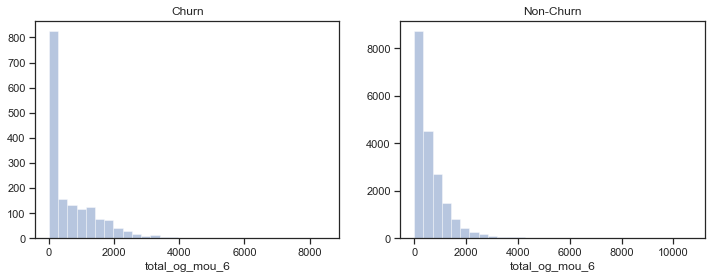

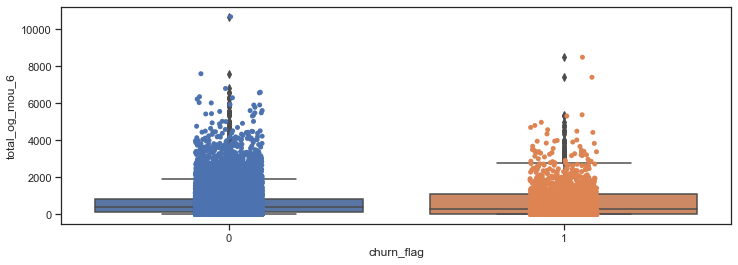

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(Telecom[Telecom['churn_flag']==1].total_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(Telecom[Telecom['churn_flag']==0].total_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_og_mou_6', data=Telecom)
sns.stripplot(x='churn_flag', y='total_og_mou_6', data=Telecom, jitter=True, edgecolor="gray")

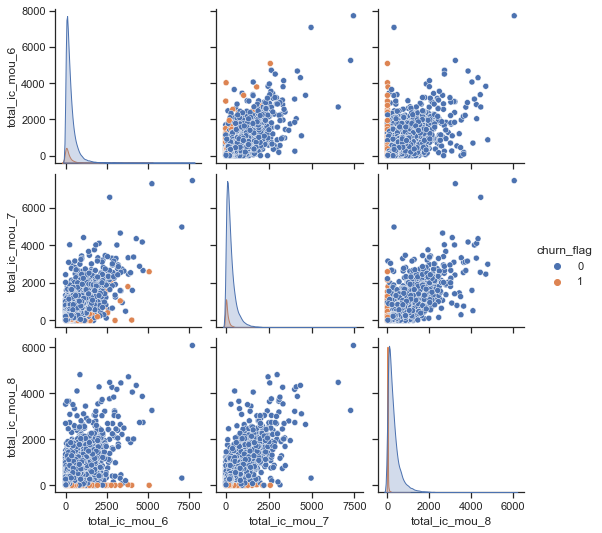

In [46]:
# totalic (All incoming calls received by a person)
sns.pairplot(data=Telecom[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','churn_flag']],hue='churn_flag')

<AxesSubplot:xlabel='churn_flag', ylabel='total_ic_mou_6'>

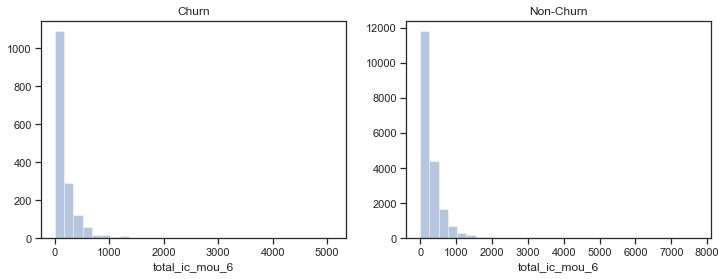

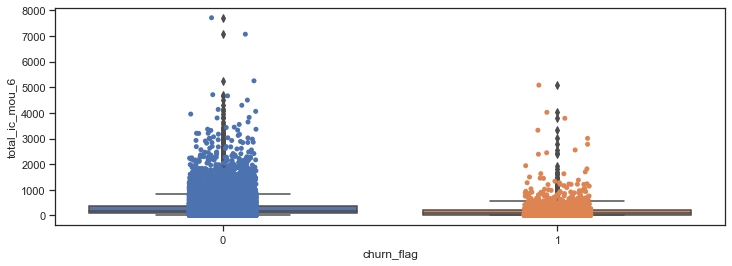

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(Telecom[Telecom['churn_flag']==1].total_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(Telecom[Telecom['churn_flag']==0].total_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_ic_mou_6', data=Telecom)
sns.stripplot(x='churn_flag', y='total_ic_mou_6', data=Telecom, jitter=True, edgecolor="gray")

In [48]:
Telecom.describe()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7,churn_flag,rech_days_left_6,rech_days_left_7,rech_days_left_8,rech_data_days_left_6,rech_data_days_left_7,rech_data_days_left_8,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8
count,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.00000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,20998.000000,2

2112.375 -302.625


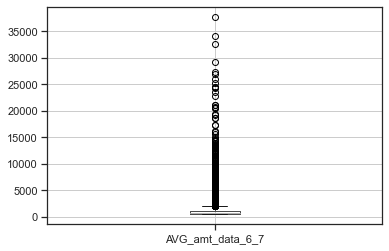

In [49]:
##Finding Outliers in Sale Price
boxplot1 = Telecom.boxplot(column=['AVG_amt_data_6_7'])
upper_SP, lower_SP = outlier(Telecom['AVG_amt_data_6_7'])
print(upper_SP, lower_SP)

In [50]:
##Dropping the outlier records and reseting the index for SalePrice
Telecom.drop(list((Telecom[(Telecom['AVG_amt_data_6_7']<lower_SP) | (Telecom['AVG_amt_data_6_7']>upper_SP)]).index),inplace=True)
Telecom.reset_index(inplace=True)
Telecom.drop('index',axis=1,inplace=True)

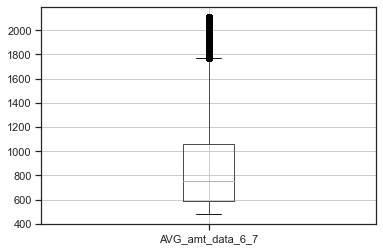

In [51]:
boxplot2 = Telecom.boxplot(column=['AVG_amt_data_6_7'])

1471.25 -306.75


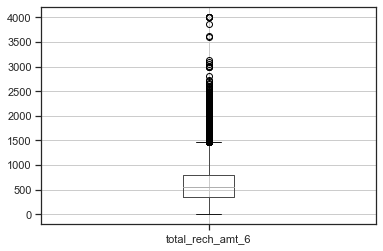

In [52]:
##Finding Outliers in total_rech_amt_6
boxplot1 = Telecom.boxplot(column=['total_rech_amt_6'])
upper_SP, lower_SP = outlier(Telecom['total_rech_amt_6'])
print(upper_SP, lower_SP)

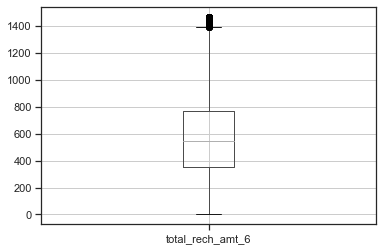

In [53]:
##Dropping the outlier records and reseting the index for total_rech_amt_6
Telecom.drop(list((Telecom[(Telecom['total_rech_amt_6']<lower_SP) | (Telecom['total_rech_amt_6']>upper_SP)]).index),inplace=True)
Telecom.reset_index(inplace=True)
Telecom.drop('index',axis=1,inplace=True)
boxplot2 = Telecom.boxplot(column=['total_rech_amt_6'])

1420.0 -292.0


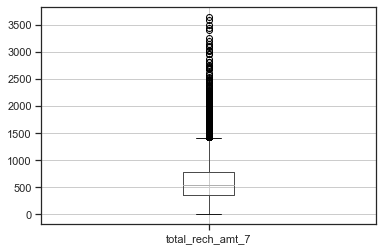

In [54]:
##Finding Outliers in total_rech_amt_7
boxplot1 = Telecom.boxplot(column=['total_rech_amt_7'])
upper_SP, lower_SP = outlier(Telecom['total_rech_amt_7'])
print(upper_SP, lower_SP)

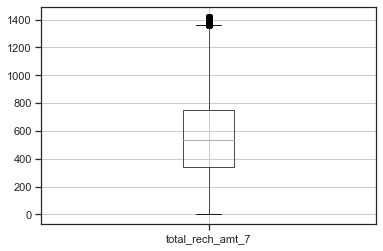

In [55]:
##Dropping the outlier records and reseting the index for total_rech_amt_7
Telecom.drop(list((Telecom[(Telecom['total_rech_amt_7']<lower_SP) | (Telecom['total_rech_amt_7']>upper_SP)]).index),inplace=True)
Telecom.reset_index(inplace=True)
Telecom.drop('index',axis=1,inplace=True)
boxplot2 = Telecom.boxplot(column=['total_rech_amt_7'])

1419.5 -456.5


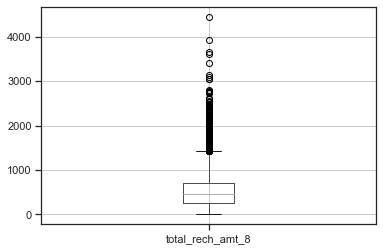

In [56]:
##Finding Outliers in total_rech_amt_8
boxplot1 = Telecom.boxplot(column=['total_rech_amt_8'])
upper_SP, lower_SP = outlier(Telecom['total_rech_amt_8'])
print(upper_SP, lower_SP)

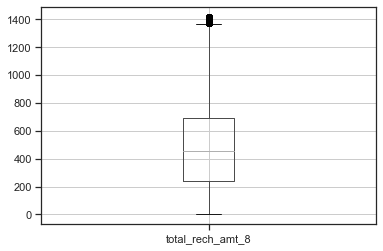

In [57]:
##Dropping the outlier records and reseting the index for total_rech_amt_8
Telecom.drop(list((Telecom[(Telecom['total_rech_amt_8']<lower_SP) | (Telecom['total_rech_amt_8']>upper_SP)]).index),inplace=True)
Telecom.reset_index(inplace=True)
Telecom.drop('index',axis=1,inplace=True)
boxplot2 = Telecom.boxplot(column=['total_rech_amt_8'])

In [58]:
Telecom.shape

(17550, 164)

In [59]:
pd.options.display.float_format = '{:.2f}'.format
joincorr= Telecom.corr()
df_corr = joincorr.stack().reset_index().sort_values(by = 0, ascending = False)
df_corr[((df_corr[0] < 1) & (df_corr[0] >= 0.4)) | ((df_corr[0] <= -0.4) & (df_corr[0] > -1))]

,level_0,level_1,0
21492,sachet_2g_8,count_rech_2g_8,0.98
17628,count_rech_2g_8,sachet_2g_8,0.98
21329,sachet_2g_7,count_rech_2g_7,0.98
17465,count_rech_2g_7,sachet_2g_7,0.98
17302,count_rech_2g_6,sachet_2g_6,0.97
21166,sachet_2g_6,count_rech_2g_6,0.97
19400,arpu_3g_7,arpu_2g_7,0.94
19883,arpu_2g_7,arpu_3g_7,0.94
19563,arpu_3g_8,arpu_2g_8,0.94
20046,arpu_2g_8,arpu_3g_8,0.94


In [60]:
# Let's create new features from good month and compare them with action phase
Telecom['AVG_arpu_6_7'] = Telecom[['arpu_6','arpu_7']].mean(axis=1)
Telecom['is_arpu_flag'] = np.where((Telecom['arpu_8'] > Telecom['AVG_arpu_6_7']), 0, 1)

Telecom['AVG_total_rech_amt_6_7'] = Telecom[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
Telecom['is_total_rech_amt_flag'] = np.where((Telecom['total_rech_amt_8'] > Telecom['AVG_total_rech_amt_6_7']), 0, 1)

Telecom['AVG_arpu_3g_6_7'] = Telecom[['arpu_3g_6','arpu_3g_7']].mean(axis=1)
Telecom['is_arpu_3g_flag'] = np.where((Telecom['arpu_3g_8'] > Telecom['AVG_arpu_3g_6_7']), 0, 1)

Telecom['AVG_arpu_2g_6_7'] = Telecom[['arpu_2g_6','arpu_2g_7']].mean(axis=1)
Telecom['is_arpu_2g_flag'] = np.where((Telecom['arpu_2g_8'] > Telecom['AVG_arpu_2g_6_7']), 0, 1)


In [61]:
Telecom.head()

,id,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7,churn_flag,rech_days_left_6,rech_days_left_7,rech_days_left_8,rech_data_days_left_6,rech_data_days_left_7,rech_data_days_left_8,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,AVG_arpu_6_7,is_arpu_flag,AVG_total_rech_amt_6_7,is_total_rech_amt_flag,AVG_arpu_3g_6_7,is_arpu_3g_flag,AVG_arpu_2g_6_7,is_arpu_2g_flag
0,4,7/31/2014,8/31/2014,240.71,128.19,101.56,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.00,0.00,15.73,0.00,0.00,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.00,0.00,0.00,4.35,0.00,0.00,0.00,0.00,0.00,0.00,17.00,0.00,0.00,0.00,0.00,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,25,10,30,25.00,41.00,25.00,7.00,6.00,6.00,0.00,1.00,0.00,390.80,308.89,213.47,0.00,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,1.00,1.00,1.00,647,0.00,0.00,0.00,0,1225.00,1337.00,1515.00,1473.00,1494.00,0,5.00,5.00,1.00,5.00,8.00,11.00,1225.00,1337.00,852.00,184.45,1,213.00,1,17.50,1,17.56,1
1,15,7/31/2014,8/31/2014,580.55,377.29,338.29,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.00,0.00,0.00,0.00,0.00,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.00,0.00,0.00,327.46,366.79,385.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.26,0.00,0.00,6.26,0.00,0.00,0.00,0.08,0.00,0.00,0.10,0.00,0.00,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.03,0.00,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,3,4,654,400,652,250,250,250,0,150,250,154.00,0.00,154.00,1.00,0.00,

In [62]:
# Create month on month change features to understand any risk associated with the churn
Telecom['loc_og_t2t_mou_7diff6'] = Telecom['loc_og_t2t_mou_7'] - Telecom['loc_og_t2t_mou_6']
Telecom['loc_og_t2m_mou_7diff6'] = Telecom['loc_og_t2m_mou_7'] - Telecom['loc_og_t2m_mou_6']
Telecom['loc_og_t2f_mou_7diff6'] = Telecom['loc_og_t2f_mou_7'] - Telecom['loc_og_t2f_mou_6']
Telecom['loc_og_t2c_mou_7diff6'] = Telecom['loc_og_t2c_mou_7'] - Telecom['loc_og_t2c_mou_6']
Telecom['loc_og_mou_7diff6'] = Telecom['loc_og_mou_7'] - Telecom['loc_og_mou_6']
Telecom['std_og_t2t_mou_7diff6'] = Telecom['std_og_t2t_mou_7'] - Telecom['std_og_t2t_mou_6']
Telecom['std_og_t2m_mou_7diff6'] = Telecom['std_og_t2m_mou_7'] - Telecom['std_og_t2m_mou_6']
Telecom['std_og_t2f_mou_7diff6'] = Telecom['std_og_t2f_mou_7'] - Telecom['std_og_t2f_mou_6']
Telecom['std_og_mou_7diff6'] = Telecom['std_og_mou_7'] - Telecom['std_og_mou_6']
Telecom['loc_og_mou_7diff6'] = Telecom['loc_og_mou_7'] - Telecom['loc_og_mou_6']
Telecom['std_og_mou_7diff6'] = Telecom['std_og_mou_7'] - Telecom['std_og_mou_6']
Telecom['isd_og_mou_7diff6'] = Telecom['isd_og_mou_7'] - Telecom['isd_og_mou_6']
Telecom['spl_og_mou_7diff6'] = Telecom['spl_og_mou_7'] - Telecom['spl_og_mou_6']
Telecom['og_others_7diff6'] = Telecom['og_others_7'] - Telecom['og_others_6']
Telecom['total_og_mou_7diff6'] = Telecom['total_og_mou_7'] - Telecom['total_og_mou_6']

Telecom['loc_og_t2t_mou_8diff7'] = Telecom['loc_og_t2t_mou_8'] - Telecom['loc_og_t2t_mou_7']
Telecom['loc_og_t2m_mou_8diff7'] = Telecom['loc_og_t2m_mou_8'] - Telecom['loc_og_t2m_mou_7']
Telecom['loc_og_t2f_mou_8diff7'] = Telecom['loc_og_t2f_mou_8'] - Telecom['loc_og_t2f_mou_7']
Telecom['loc_og_t2c_mou_8diff7'] = Telecom['loc_og_t2c_mou_8'] - Telecom['loc_og_t2c_mou_7']
Telecom['loc_og_mou_8diff7'] = Telecom['loc_og_mou_8'] - Telecom['loc_og_mou_7']
Telecom['std_og_t2t_mou_8diff7'] = Telecom['std_og_t2t_mou_8'] - Telecom['std_og_t2t_mou_7']
Telecom['std_og_t2m_mou_8diff7'] = Telecom['std_og_t2m_mou_8'] - Telecom['std_og_t2m_mou_7']
Telecom['std_og_t2f_mou_8diff7'] = Telecom['std_og_t2f_mou_8'] - Telecom['std_og_t2f_mou_7']
Telecom['std_og_mou_8diff7'] = Telecom['std_og_mou_8'] - Telecom['std_og_mou_7']
Telecom['loc_og_mou_8diff7'] = Telecom['loc_og_mou_8'] - Telecom['loc_og_mou_7']
Telecom['std_og_mou_8diff7'] = Telecom['std_og_mou_8'] - Telecom['std_og_mou_7']
Telecom['isd_og_mou_8diff7'] = Telecom['isd_og_mou_8'] - Telecom['isd_og_mou_7']
Telecom['spl_og_mou_8diff7'] = Telecom['spl_og_mou_8'] - Telecom['spl_og_mou_7']
Telecom['og_others_8diff7'] = Telecom['og_others_8'] - Telecom['og_others_7']
Telecom['total_og_mou_8diff7'] = Telecom['total_og_mou_8'] - Telecom['total_og_mou_7']

Telecom['loc_ic_t2t_mou_7diff6'] = Telecom['loc_ic_t2t_mou_7'] - Telecom['loc_ic_t2t_mou_6']
Telecom['loc_ic_t2m_mou_7diff6'] = Telecom['loc_ic_t2m_mou_7'] - Telecom['loc_ic_t2m_mou_6']
Telecom['loc_ic_t2f_mou_7diff6'] = Telecom['loc_ic_t2f_mou_7'] - Telecom['loc_ic_t2f_mou_6']
Telecom['loc_ic_mou_7diff6'] = Telecom['loc_ic_mou_7'] - Telecom['loc_ic_mou_6']
Telecom['std_ic_t2t_mou_7diff6'] = Telecom['std_ic_t2t_mou_7'] - Telecom['std_ic_t2t_mou_6']
Telecom['std_ic_t2m_mou_7diff6'] = Telecom['std_ic_t2m_mou_7'] - Telecom['std_ic_t2m_mou_6']
Telecom['std_ic_t2f_mou_7diff6'] = Telecom['std_ic_t2f_mou_7'] - Telecom['std_ic_t2f_mou_6']
Telecom['std_ic_mou_7diff6'] = Telecom['std_ic_mou_7'] - Telecom['std_ic_mou_6']
Telecom['loc_ic_mou_7diff6'] = Telecom['loc_ic_mou_7'] - Telecom['loc_ic_mou_6']
Telecom['std_ic_mou_7diff6'] = Telecom['std_ic_mou_7'] - Telecom['std_ic_mou_6']
Telecom['spl_ic_mou_7diff6'] = Telecom['spl_ic_mou_7'] - Telecom['spl_ic_mou_6']
Telecom['isd_ic_mou_7diff6'] = Telecom['isd_ic_mou_7'] - Telecom['isd_ic_mou_6']
Telecom['ic_others_7diff6'] = Telecom['ic_others_7'] - Telecom['ic_others_6']
Telecom['total_ic_mou_7diff6'] = Telecom['total_ic_mou_7'] - Telecom['total_ic_mou_6']

Telecom['loc_ic_t2t_mou_8diff7'] = Telecom['loc_ic_t2t_mou_8'] - Telecom['loc_ic_t2t_mou_7']
Telecom['loc_ic_t2m_mou_8diff7'] = Telecom['loc_ic_t2m_mou_8'] - Telecom['loc_ic_t2m_mou_7']
Telecom['loc_ic_t2f_mou_8diff7'] = Telecom['loc_ic_t2f_mou_8'] - Telecom['loc_ic_t2f_mou_7']
Telecom['loc_ic_mou_8diff7'] = Telecom['loc_ic_mou_8'] - Telecom['loc_ic_mou_7']
Telecom['std_ic_t2t_mou_8diff7'] = Telecom['std_ic_t2t_mou_8'] - Telecom['std_ic_t2t_mou_7']
Telecom['std_ic_t2m_mou_8diff7'] = Telecom['std_ic_t2m_mou_8'] - Telecom['std_ic_t2m_mou_7']
Telecom['std_ic_t2f_mou_8diff7'] = Telecom['std_ic_t2f_mou_8'] - Telecom['std_ic_t2f_mou_7']
Telecom['std_ic_mou_8diff7'] = Telecom['std_ic_mou_8'] - Telecom['std_ic_mou_7']
Telecom['loc_ic_mou_8diff7'] = Telecom['loc_ic_mou_8'] - Telecom['loc_ic_mou_7']
Telecom['std_ic_mou_8diff7'] = Telecom['std_ic_mou_8'] - Telecom['std_ic_mou_7']
Telecom['spl_ic_mou_8diff7'] = Telecom['spl_ic_mou_8'] - Telecom['spl_ic_mou_7']
Telecom['isd_ic_mou_8diff7'] = Telecom['isd_ic_mou_8'] - Telecom['isd_ic_mou_7']
Telecom['ic_others_8diff7'] = Telecom['ic_others_8'] - Telecom['ic_others_7']
Telecom['total_ic_mou_8diff7'] = Telecom['total_ic_mou_8'] - Telecom['total_ic_mou_7']

Telecom['onnet_mou_7diff6'] = Telecom['onnet_mou_7'] - Telecom['onnet_mou_6']
Telecom['onnet_mou_8diff7'] = Telecom['onnet_mou_8'] - Telecom['onnet_mou_7']

Telecom['offnet_mou_7diff6'] = Telecom['offnet_mou_7'] - Telecom['offnet_mou_6']
Telecom['offnet_mou_8diff7'] = Telecom['offnet_mou_8'] - Telecom['offnet_mou_7']

Telecom['roam_ic_mou_7diff6'] = Telecom['roam_ic_mou_7'] - Telecom['roam_ic_mou_6']
Telecom['roam_ic_mou_8diff7'] = Telecom['roam_ic_mou_8'] - Telecom['roam_ic_mou_7']

Telecom['roam_og_mou_7diff6'] = Telecom['roam_og_mou_7'] - Telecom['roam_og_mou_6']
Telecom['roam_og_mou_8diff7'] = Telecom['roam_og_mou_8'] - Telecom['roam_og_mou_7']

Telecom['total_rech_amt_7diff6'] = Telecom['total_rech_amt_7'] - Telecom['total_rech_amt_6']
Telecom['total_rech_amt_8diff7'] = Telecom['total_rech_amt_8'] - Telecom['total_rech_amt_7']

Telecom['vol_2g_mb_7diff6'] = Telecom['vol_2g_mb_7'] - Telecom['vol_2g_mb_6']
Telecom['vol_2g_mb_8diff7'] = Telecom['vol_2g_mb_8'] - Telecom['vol_2g_mb_7']

Telecom['vol_3g_mb_7diff6'] = Telecom['vol_3g_mb_7'] - Telecom['vol_3g_mb_6']
Telecom['vol_3g_mb_8diff7'] = Telecom['vol_3g_mb_8'] - Telecom['vol_3g_mb_7']

Telecom['vbc_3g_7diff6'] = Telecom['jul_vbc_3g'] - Telecom['jun_vbc_3g']
Telecom['vbc_3g_8diff7'] = Telecom['aug_vbc_3g'] - Telecom['jul_vbc_3g']

In [63]:
Telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17550 entries, 0 to 17549
Data columns (total 238 columns):
 #    Column                  Dtype  
---   ------                  -----  
 0    id                      int64  
 1    last_date_of_month_7    object 
 2    last_date_of_month_8    object 
 3    arpu_6                  float64
 4    arpu_7                  float64
 5    arpu_8                  float64
 6    onnet_mou_6             float64
 7    onnet_mou_7             float64
 8    onnet_mou_8             float64
 9    offnet_mou_6            float64
 10   offnet_mou_7            float64
 11   offnet_mou_8            float64
 12   roam_ic_mou_6           float64
 13   roam_ic_mou_7           float64
 14   roam_ic_mou_8           float64
 15   roam_og_mou_6           float64
 16   roam_og_mou_7           float64
 17   roam_og_mou_8           float64
 18   loc_og_t2t_mou_6        float64
 19   loc_og_t2t_mou_7        float64
 20   loc_og_t2t_mou_8        float64
 21   loc_og_t2m

In [64]:
# Removing last_date_of_month_7 & last_date_of_month_8 as we have already deduced more meaningfull columns from it.
Telecom = Telecom.drop(["last_date_of_month_7"], axis = 1)
Telecom = Telecom.drop(["last_date_of_month_8"], axis = 1)
Telecom = Telecom.drop(["id"], axis = 1)

In [65]:
#dropping more columns
Telecom.drop(['arpu_6','arpu_7','onnet_mou_6','onnet_mou_7','offnet_mou_6','offnet_mou_7',
         'roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_6','roam_og_mou_7',
         'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_6','loc_og_t2m_mou_7',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_6','loc_og_t2c_mou_7',
         'std_og_t2t_mou_6','std_og_t2t_mou_7', 'std_og_t2m_mou_6','std_og_t2m_mou_7',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','isd_og_mou_6','isd_og_mou_7',
         'spl_og_mou_6','spl_og_mou_7', 'og_others_6','og_others_7',
         'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6','std_ic_t2t_mou_7',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7', 'std_ic_t2f_mou_6','std_ic_t2f_mou_7',
         'spl_ic_mou_6','spl_ic_mou_7', 'isd_ic_mou_6','isd_ic_mou_7',
         'ic_others_6','ic_others_7', 'total_rech_amt_6','total_rech_amt_7',
         'vol_2g_mb_6','vol_2g_mb_7', 'vol_3g_mb_6','vol_3g_mb_7',
         'arpu_3g_6','arpu_3g_7', 'arpu_2g_6','arpu_2g_7',
         'jun_vbc_3g','jul_vbc_3g', 'loc_og_mou_6', 'loc_og_mou_7','std_og_mou_6', 'std_og_mou_7',
          'total_og_mou_6', 'total_og_mou_7','loc_ic_mou_6', 'loc_ic_mou_7',
          'std_ic_mou_6', 'std_ic_mou_7','total_ic_mou_6', 'total_ic_mou_7',
          'total_rech_num_6', 'total_rech_num_7','night_pck_user_6', 'night_pck_user_7',
          'monthly_2g_6', 'monthly_2g_7','sachet_2g_6', 'sachet_2g_7',
          'monthly_3g_6', 'monthly_3g_7','sachet_3g_6', 'sachet_3g_7','fb_user_6', 'fb_user_7'
        ], axis=1, inplace=True)

In [66]:
Telecom.shape

(17550, 149)

In [67]:
# Create correlation matrix
corr_matrix = Telecom.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.80)]

print("HIGHLY CORRELATED FEATURES IN DATA SET:{}\n\n{}".format(len(high_corr_features), high_corr_features))

HIGHLY CORRELATED FEATURES IN DATA SET:26

['std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'total_rech_amt_8', 'arpu_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'amt_data_7', 'total_rech_data_amt_6', 'total_rech_data_amt_7', 'AVG_total_rech_amt_6_7', 'AVG_arpu_2g_6_7', 'total_og_mou_7diff6', 'og_others_8diff7', 'total_og_mou_8diff7', 'std_ic_mou_7diff6', 'total_ic_mou_7diff6', 'total_ic_mou_8diff7', 'onnet_mou_7diff6', 'onnet_mou_8diff7', 'offnet_mou_7diff6', 'offnet_mou_8diff7']


### OBSERVATION: 26 highly correlated features (> 80%) found in the data set.
### NOTE: We are not dropping these columns manually rather using feature reduction methods to do the job. We worked with RFE, LASSO and PCA.

In [68]:
Telecom.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17550 entries, 0 to 17549
Data columns (total 149 columns):
 #    Column                  Dtype  
---   ------                  -----  
 0    arpu_8                  float64
 1    onnet_mou_8             float64
 2    offnet_mou_8            float64
 3    roam_ic_mou_8           float64
 4    roam_og_mou_8           float64
 5    loc_og_t2t_mou_8        float64
 6    loc_og_t2m_mou_8        float64
 7    loc_og_t2f_mou_8        float64
 8    loc_og_t2c_mou_8        float64
 9    loc_og_mou_8            float64
 10   std_og_t2t_mou_8        float64
 11   std_og_t2m_mou_8        float64
 12   std_og_t2f_mou_8        float64
 13   std_og_mou_8            float64
 14   isd_og_mou_8            float64
 15   spl_og_mou_8            float64
 16   og_others_8             float64
 17   total_og_mou_8          float64
 18   loc_ic_t2t_mou_8        float64
 19   loc_ic_t2m_mou_8        float64
 20   loc_ic_t2f_mou_8        float64
 21   loc_ic_mou

In [69]:
#Ensuring there are no nulls
Telecom.replace([np.inf, -np.inf], np.nan,inplace=True)
Telecom.fillna(0,inplace=True)

In [70]:
Telecom.isnull().values.any()

False

In [71]:
#Model Creation
X = Telecom[Telecom.columns[~Telecom.columns.isin(['churn_flag'])]]
Y = Telecom['churn_flag']

In [72]:
# scaling the features in train and test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [73]:
# Splitting the data into train and test
np.random.seed(0)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std,Y, train_size=0.8,test_size=0.2,random_state=100)

In [74]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (14040, 148)
Training dataset target size (14040,)
Test dataset size (3510, 148)
Test dataset target size (3510,)


In [75]:
y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data: {}".format(y_train_imb))
print("Imbalance in Test Data: {}".format(y_test_imb))

Imbalance in Train Data: 0.08660320408637102
Imbalance in Test Data: 0.08500772797527048


In [76]:
## Below is the command to install imblearn package for fixing class imbalance.
## !pip install imblearn


In [77]:
# (Training) Balance Data-Set --- SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)

In [78]:
print("X_tr Dataframe Shape {}".format(X_tr.shape))
print("y_tr Dataframe Shape {}".format(y_tr.shape))

data_imbalance = (y_tr != 0).sum()/(y_tr == 0).sum()
print("Imbalance in Train Data: {}".format(data_imbalance))

X_tr Dataframe Shape (25842, 148)
y_tr Dataframe Shape (25842,)
Imbalance in Train Data: 1.0


In [79]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [80]:
#Doing the PCA on the train data
pca.fit(X_tr)

PCA(random_state=42, svd_solver='randomized')

In [81]:
pca.components_

array([[ 1.94247554e-01,  6.16699476e-02,  9.45684254e-02, ...,
         1.42874585e-02,  2.71941027e-02,  9.05446618e-03],
       [ 1.43170161e-01,  1.15714922e-01,  1.40578323e-01, ...,
         1.27771557e-02,  3.15403353e-02,  2.01457418e-02],
       [ 1.34423138e-01,  8.03646870e-02,  1.16273023e-01, ...,
         5.49109374e-02, -2.47404929e-02,  3.13744934e-02],
       ...,
       [-0.00000000e+00,  8.61344577e-15,  6.58165542e-15, ...,
        -1.42247325e-16,  1.58293517e-17,  3.12250226e-17],
       [-0.00000000e+00,  1.29323458e-14,  1.35711341e-14, ...,
         1.29453739e-16,  5.25634766e-17,  4.06575815e-17],
       [ 0.00000000e+00, -9.56773362e-15, -9.17714955e-15, ...,
        -1.15489190e-16, -5.43820810e-17, -1.97107873e-17]])

In [82]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.19,0.14,arpu_8
1,0.06,0.12,onnet_mou_8
2,0.09,0.14,offnet_mou_8
3,-0.02,0.03,roam_ic_mou_8
4,-0.03,0.06,roam_og_mou_8


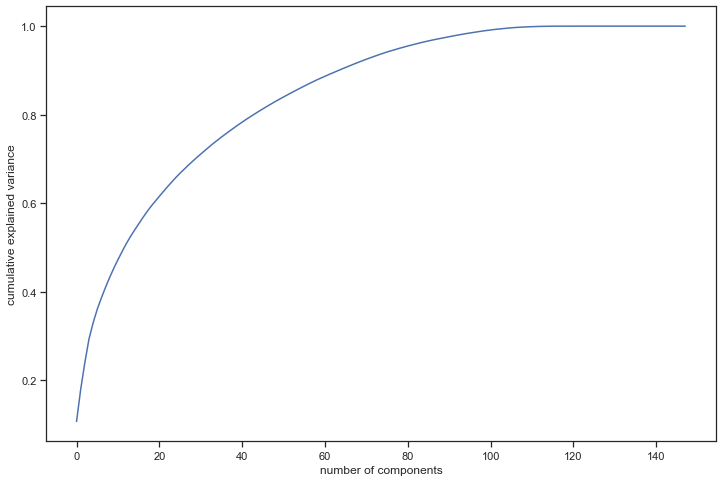

In [83]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [84]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.71,  17.98,  24.01,  29.34,  32.98,  36.08,  38.64,  41.04,
        43.28,  45.34,  47.27,  49.1 ,  50.86,  52.46,  53.93,  55.34,
        56.74,  58.08,  59.33,  60.47,  61.59,  62.7 ,  63.78,  64.83,
        65.85,  66.81,  67.72,  68.61,  69.48,  70.32,  71.14,  71.94,
        72.74,  73.52,  74.26,  74.98,  75.69,  76.37,  77.05,  77.71,
        78.36,  78.99,  79.59,  80.19,  80.78,  81.35,  81.91,  82.46,
        83.  ,  83.53,  84.04,  84.54,  85.04,  85.53,  86.02,  86.5 ,
        86.97,  87.43,  87.88,  88.3 ,  88.71,  89.12,  89.52,  89.92,
        90.31,  90.7 ,  91.09,  91.47,  91.84,  92.2 ,  92.56,  92.9 ,
        93.23,  93.56,  93.88,  94.19,  94.47,  94.75,  95.02,  95.29,
        95.54,  95.78,  96.02,  96.25,  96.47,  96.68,  96.88,  97.07,
        97.26,  97.45,  97.63,  97.81,  97.98,  98.15,  98.31,  98.46,
        98.61,  98.76,  98.9 ,  99.03,  99.15,  99.26,  99.36,  99.46,
        99.55,  99.63,  99.7 ,  99.76,  99.81,  99.86,  99.89,  99.92,
      

In [85]:
#Using incremental PCA for efficiency; setting it to 80 as that seems to explain 90% of the variance
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=80)
df_train_pca1 = pca_final.fit_transform(X_tr)
df_train_pca1.shape

(25842, 80)

In [89]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca1.transpose())
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.03657747469609878 , min corr:  -0.04691606821615193


In [95]:
#Applying selected components to the test data
df_test_pca1 = pca_final.transform(X_test)
df_test_pca1.shape

(3510, 80)

In [96]:
# run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk1 = LogisticRegression(C=1e9)
model_pca = logsk1.fit(df_train_pca1, y_tr)

# Predicted probabilities
y_pred = logsk1.predict(df_test_pca1)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [97]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))
print("LogisticRegression accuracy with PCA: ",accuracy_score(y_test,y_pred))

[[3013  222]
 [  16  259]]
LogisticRegression accuracy with PCA:  0.9321937321937321


In [98]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca1)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.98'

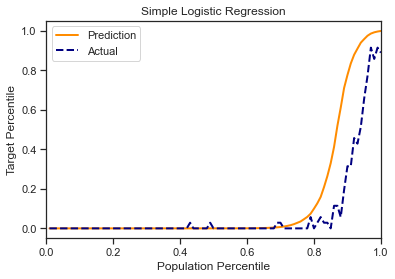

In [99]:
plotLiftChart(y_test.values,pred_probs_test,"Simple Logistic Regression")

In [100]:
## Create Stratefied Kfold Samples
from sklearn.model_selection  import StratifiedKFold
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)

In [101]:
from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [106]:
searchCV.fit(df_train_pca1,y_tr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.8s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=StratifiedKFold(n_splits=4, random_state=100, shuffle=True),
                     n_jobs=-1, random_state=777, scoring='roc_auc',
                     solver='newton-cg', tol=1, verbose=2)

In [107]:
print("final selected 1/lambda is ", searchCV.C_)
print("final selected lambda is ", 1/searchCV.C_)

final selected 1/lambda is  [10.]
final selected lambda is  [0.1]


              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3235
           1       0.54      0.94      0.69       275

    accuracy                           0.93      3510
   macro avg       0.77      0.94      0.82      3510
weighted avg       0.96      0.93      0.94      3510

Accuracy for the test dataset 93.2%
ROC for the test dataset 97.9%
Confusion Matrix
[[3013  222]
 [  16  259]]


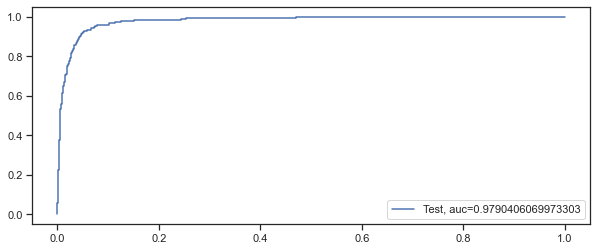

In [110]:
#train data
preds_L2Search = searchCV.predict(df_test_pca1)
preds_L2Search_probs = searchCV.predict_proba(df_test_pca1)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
print("Confusion Matrix")
print(confusion_matrix(y_test,preds_L2Search))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

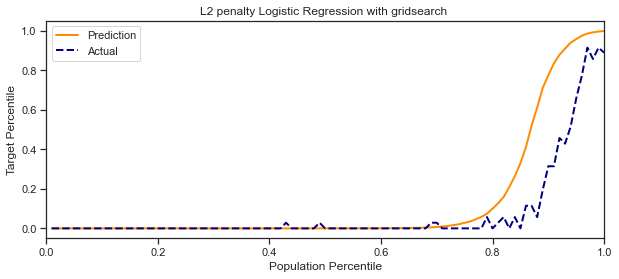

In [111]:
plotLiftChart(y_test.values,preds_L2Search_probs,"L2 penalty Logistic Regression with gridsearch ")

In [114]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
RFC_balanced = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                                      min_samples_split=500, min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, max_features='auto', 
                                      max_leaf_nodes=None, 
                                      bootstrap=True, oob_score=False, n_jobs=-1, 
                                      random_state=100, verbose=0, warm_start=False, 
                                      class_weight="balanced_subsample")

In [115]:
TrainedRFC= RFC_balanced.fit(df_train_pca1,y_tr)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      3235
           1       0.45      0.75      0.57       275

    accuracy                           0.91      3510
   macro avg       0.72      0.84      0.76      3510
weighted avg       0.94      0.91      0.92      3510

Accuracy for the test dataset 90.9%
Confusion Matrix
[[2985  250]
 [  68  207]]
ROC for the test dataset 93.3%


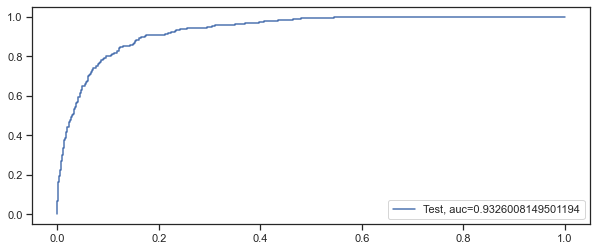

In [118]:
preds_RFC=TrainedRFC.predict(df_test_pca1)
preds_probs_RFC=TrainedRFC.predict_proba(df_test_pca1)[:,1]

print(classification_report(y_test, preds_RFC))
accuracy = metrics.accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

print("Confusion Matrix")
print(confusion_matrix(y_test,preds_RFC))

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_RFC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

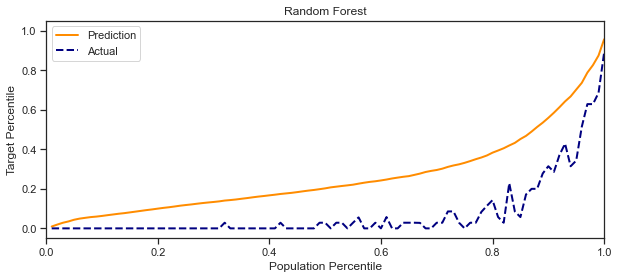

In [119]:
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest")

<Figure size 720x288 with 0 Axes>

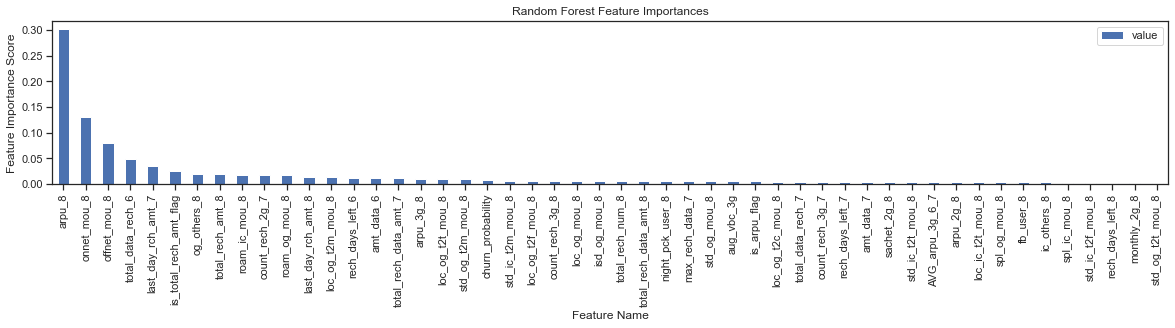

In [121]:
importances = TrainedRFC.feature_importances_
col_names =  X.columns

sorted_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})

plt.clf()
from pylab import rcParams
rcParams['figure.figsize'] = 20, 3
sorted_feature_importance[0:50].plot(x='colName', y='value' , kind='bar', title='Random Forest Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')

plt.show()